# Example `KBackground.Estimator` workflow with Kepler TPFs

In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
from kbackground import Estimator
import astropy.units as u

In [3]:
# This let's us have debugging messages!
import kbackground
kbackground.log.setLevel("INFO")

First we are going to get a number of the TPFs in a large superstamp in campaign 8. This will let us see a patch of data with a rolling band.

In [1687]:
tpfs = lk.search_targetpixelfile('KIC 8557374', quarter=5, cadence='long', radius=10 * u.arcmin).download_all()

Next we will extract the row, column and flux values from all the TPFs.

In [1688]:
rows, columns, fluxs, mission_bkgs, cadencenos = [], [], [], [], []
for tpf in tpfs:
    column, row = np.meshgrid(np.arange(tpf.column, tpf.shape[2] + tpf.column), np.arange(tpf.row, tpf.shape[1] + tpf.row))
    aper = np.nansum(tpf.flux.value, axis=0) != 0
    rows.append(row[aper])
    columns.append(column[aper])
    fluxs.append(tpf.flux.value[:, aper] + np.nan_to_num(tpf.flux_bkg.value[:, aper]))
    cadencenos.append(tpf.cadenceno)

Next we can build the `Estimator` object, passing in the row, column, and flux values from all the TPFs.

In [1689]:
r, c, f = np.hstack(rows), np.hstack(columns), np.hstack(fluxs)
k = np.isfinite(f).all(axis=0)

In [1723]:
e = Estimator(cadencenos[0], r[k], c[k], f[:, k], mask=f[:, k].mean(axis=0) < 230, tknotspacing=4, xknotspacing=6)

2022-01-21 16:49:19,667 - kbackground.kbackground - INFO - new `kbackground` Object. tknotspacing:4, xknotspacing:4
2022-01-21 16:49:19,668 - kbackground.kbackground - INFO - ntimes x npixels : (4492, 2194)
2022-01-21 16:49:20,225 - kbackground.kbackground - INFO - 2 break points
2022-01-21 16:49:20,235 - kbackground.kbackground - INFO - Fitting model for segment 1/36
2022-01-21 16:49:20,388 - kbackground.kbackground - INFO - Fitting model for segment 2/36
2022-01-21 16:49:20,532 - kbackground.kbackground - INFO - Fitting model for segment 3/36
2022-01-21 16:49:20,682 - kbackground.kbackground - INFO - Fitting model for segment 4/36
2022-01-21 16:49:20,825 - kbackground.kbackground - INFO - Fitting model for segment 5/36
2022-01-21 16:49:20,978 - kbackground.kbackground - INFO - Fitting model for segment 6/36
2022-01-21 16:49:21,130 - kbackground.kbackground - INFO - Fitting model for segment 7/36
2022-01-21 16:49:21,281 - kbackground.kbackground - INFO - Fitting model for segment 8/36

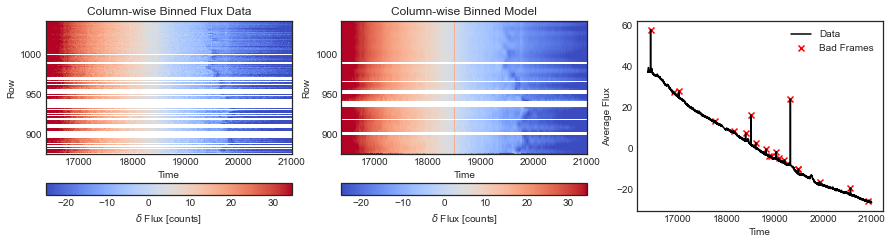

In [1724]:
e.plot();

### Correction for faint pixels

Below we show the correction for a subset of the faint pixels in this dataset. The correction largely removes the long term trends from the dataset.

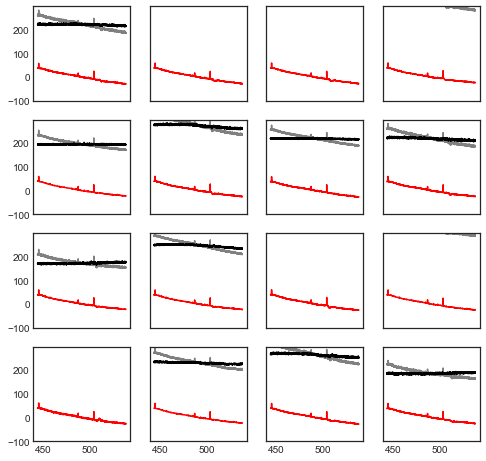

In [1725]:
dim_pix = np.where(np.diff(np.nanpercentile(e.flux, (5, 95), axis=0), axis=0)[0] < 80)[0]
fig, ax = plt.subplots(4, 4, figsize=(8, 8), sharex=True, sharey=True)
kdx = -1
for idx, jdx in enumerate(np.random.choice(dim_pix, 16)):
    if idx % 4 == 0:
        kdx += 1
    ax[kdx, idx % 4].plot(tpf.time.value, e.flux[:, jdx], label='Data', c='grey')
    ax[kdx, idx % 4].plot(tpf.time.value, e.flux[:, jdx] - e.model[:, jdx], label='Data', c='k')
    ax[kdx, idx % 4].plot(tpf.time.value, e.model[:, jdx], label='Model', c='r')
    ax[kdx, idx % 4].set(ylim=(-100, ax[kdx, idx % 4].get_ylim()[1]))

In [1726]:
import pickle

In [1727]:
# This let's us have debugging messages!
import kbackground
kbackground.log.setLevel("INFO")

In [1781]:
from astropy.stats import sigma_clip
# Load pickle
e = pickle.load(open('/Users/ch/Downloads/bkg_estimator_augmented.pickle', 'rb'))
# Recalculate model
e.tknotspacing = 5
e.xknotspacing = 10
e.__post_init__()

2022-01-21 16:55:48,298 - kbackground.kbackground - INFO - new `kbackground` Object. tknotspacing:5, xknotspacing:5
2022-01-21 16:55:48,298 - kbackground.kbackground - INFO - ntimes x npixels : (4487, 8438)
2022-01-21 16:55:50,402 - kbackground.kbackground - INFO - 2 break points
2022-01-21 16:55:50,524 - kbackground.kbackground - INFO - Fitting model for segment 1/28
2022-01-21 16:55:51,049 - kbackground.kbackground - INFO - Fitting model for segment 2/28
2022-01-21 16:55:51,440 - kbackground.kbackground - INFO - Fitting model for segment 3/28
2022-01-21 16:55:51,782 - kbackground.kbackground - INFO - Fitting model for segment 4/28
2022-01-21 16:55:52,132 - kbackground.kbackground - INFO - Fitting model for segment 5/28
2022-01-21 16:55:52,493 - kbackground.kbackground - INFO - Fitting model for segment 6/28
2022-01-21 16:55:52,829 - kbackground.kbackground - INFO - Fitting model for segment 7/28
2022-01-21 16:55:53,173 - kbackground.kbackground - INFO - Fitting model for segment 8/28

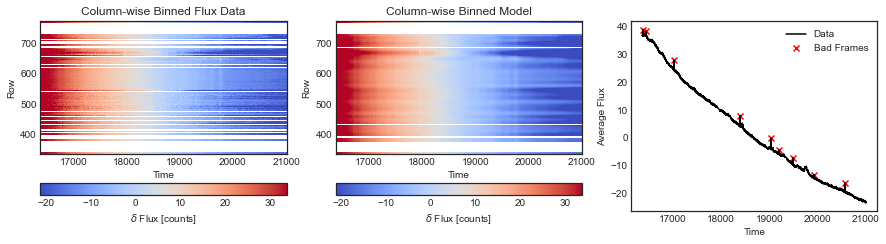

In [1782]:
e.plot();

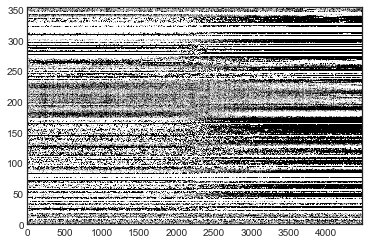

In [1783]:
plt.pcolormesh(e.bf - e._model, vmin=-1, vmax=1)

(-100.0, 400.0)

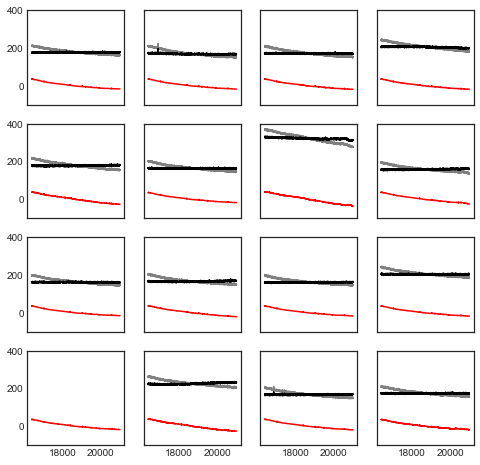

In [1784]:
dim_pix = np.where(np.diff(np.nanpercentile(e.flux, (5, 95), axis=0), axis=0)[0] < 80)[0]
fig, ax = plt.subplots(4, 4, figsize=(8, 8), sharex=True, sharey=True)
kdx = -1
for idx, jdx in enumerate(np.random.choice(dim_pix, 16)):
    if idx % 4 == 0:
        kdx += 1
    ax[kdx, idx % 4].plot(e.time, e.flux[:, jdx], label='Data', c='grey')
    ax[kdx, idx % 4].plot(e.time, e.flux[:, jdx] - e.model[:, jdx], label='Data', c='k')
    ax[kdx, idx % 4].plot(e.time, e.model[:, jdx], label='Model', c='r')
ax[0, 0].set_ylim(-100, 400)

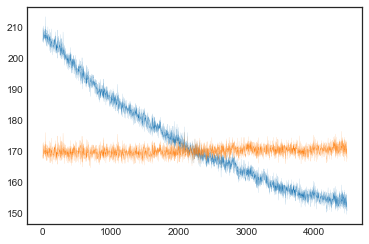

In [1811]:
tdx = 3006
#plt.plot(e.flux[:, tdx] - np.polyval(np.polyfit(e.time, e.flux[:, tdx], 2), e.time) + e.flux[:, tdx].mean(), lw=0.1)
plt.plot(e.flux[:, tdx], lw=0.1)
plt.plot(e.flux[:, tdx] - e.model[:, tdx], lw=0.1)

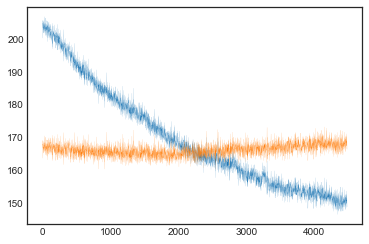

In [1812]:
tdx = 1600
#plt.plot(e.flux[:, tdx] - np.polyval(np.polyfit(e.time, e.flux[:, tdx], 2), e.time) + e.flux[:, tdx].mean(), lw=0.1)
plt.plot(e.flux[:, tdx], lw=0.1)
plt.plot(e.flux[:, tdx] - e.model[:, tdx], lw=0.1)

In [1038]:
def _make_A2d(self, x, y):
    """Makes a reasonable design matrix for the rolling band."""
    x_spline = sparse.csr_matrix(
        np.asarray(
            dmatrix(
                "bs(x, knots=knots, degree=3, include_intercept=True)",
                {"x": np.hstack([0, x, 1400]), "knots": self.xknots},
            )
        )
    )[1:-1]
    x_spline = x_spline[:, np.asarray((x_spline.sum(axis=0) != 0))[0]]
    y_spline = sparse.csr_matrix(
        np.asarray(
            dmatrix(
                "bs(x, knots=knots, degree=2, include_intercept=True)",
                {"x": np.hstack([0, list(y), 1400]), "knots": np.linspace(27, 1040, 12)[1:-1]},
            )
        )
    )[1:-1]
    y_spline = y_spline[:, np.asarray((y_spline.sum(axis=0) != 0))[0]]
    X = sparse.hstack(
        [x_spline.multiply(y_spline[:, idx]) for idx in range(y_spline.shape[1])],
        format="csr",
    )
    return X

In [1158]:
A2d = _make_A2d(e, e.row, e.column)

In [1160]:
j = e.mask

In [1250]:
model = np.zeros_like(e.flux)
for tdx in range(500):
    t = e.time[tdx]
    k = np.abs(e.time - t) < 5
    A3d = sparse.hstack([sparse.vstack([A2d * (t1 - t)**jdx for t1 in e.time[k]]) for jdx in range(3)], 'csr')
    prior_sigma = np.ones(A3d.shape[1])*100
    f2 = e.flux[k].ravel()
    j = (np.ones(k.sum(), bool)[:, None] * e.mask).ravel()
    f2 -= np.median(f2[j])
    w = np.linalg.solve(A3d[j].T.dot(A3d[j]) + np.diag(1/prior_sigma**2), A3d[j].T.dot(f2[j]))
    model[tdx] = A3d.dot(w).reshape((k.sum(), e.flux.shape[1]))[e.time[k] == t][0]

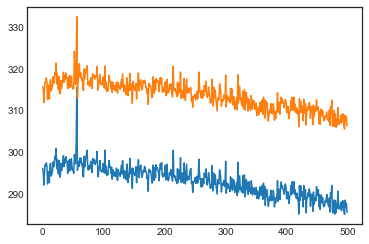

In [1262]:
plt.plot(e.flux[:500, 900])
plt.plot(e.flux[:500, 900] - model[:500, 900])

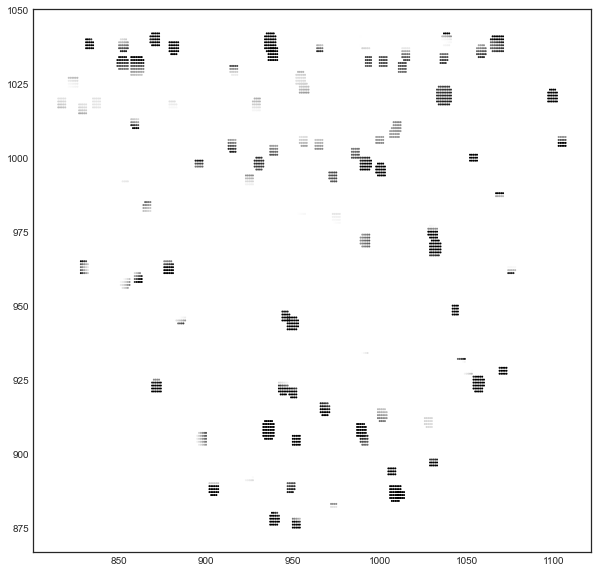

In [1252]:
plt.figure(figsize=(10, 10))
plt.scatter(e.column, e.row, c=model[8], s=1, vmin=-10, vmax=10)

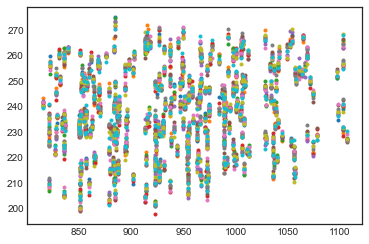

In [949]:
plt.plot(e.column[e.mask], f.T, marker='.', ls='')

In [915]:
A1.shape

(21940, 468)

In [916]:
A1.T.dot(A1)

<468x468 sparse matrix of type '<class 'numpy.float64'>'
	with 47080 stored elements in Compressed Sparse Row format>

In [651]:
from fbpca import pca
from astropy.convolution import convolve, Gaussian1DKernel

array([nan, nan, nan, ..., nan, nan, nan])

In [781]:
y = e.bf[np.isfinite(e.bf.mean(axis=1)), :]
x = np.arange(e.time[0], e.time[-1] + 1)
m = np.ones_like(x, float)
m[np.in1d(x, e.time[e.bad_frames])] = np.nan
smoothy = np.asarray([convolve(np.interp(x, e.time, y1), Gaussian1DKernel(5), boundary='extend') for y1 in y])
smoothy = smoothy[:, np.in1d(x, e.time)]
#y[:, e.bad_frames] = np.nan

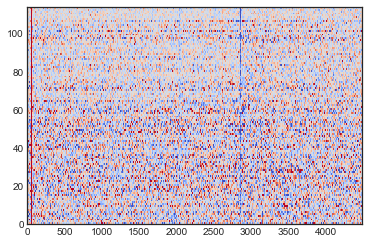

In [782]:
U, s, V = pca(smoothy.T, y.shape[0]//10, n_iter=10, raw=True)
plt.pcolormesh(y - U.dot(np.diag(s).dot(V)).T, vmin=-3, vmax=3, cmap='coolwarm')
U = np.hstack([np.vstack([(e.time - e.time.mean())**idx for idx in range(3)]).T, U])

In [783]:
x_spline = sparse.csr_matrix(
        np.asarray(
            dmatrix(
                "bs(x, knots=knots, degree=3, include_intercept=True)",
                {"x": np.hstack([0, e.unq_row, 1400]), "knots": np.arange(20+0.5, 1108, 5)},
            )
        )
    )[1:-1]
x_spline = x_spline[:, np.asarray((x_spline.sum(axis=0) != 0))[0]]
X = (
    sparse.hstack([x_spline] * e.time.shape[0])
    .reshape((x_spline.shape[0] * e.time.shape[0], x_spline.shape[1]))
    .tocsr()
)

In [784]:
T = np.vstack([U] * x_spline.shape[0])

In [785]:
A1 = sparse.hstack([X.multiply(t[:, None]) for t in T.T]).tocsr()
badA = sparse.vstack(
    [
        sparse.csr_matrix(
            (
                np.in1d(np.arange(len(e.time)), b)
                * np.ones(e.bf.shape, bool)
            ).ravel()
        )
        for b in e.bad_frames
    ]
).T
A = sparse.hstack([A1, badA], "csr")

In [786]:
prior_sigma = np.ones(A.shape[1]) * 100
k1 = np.isfinite(e.bf.ravel())
sigma_w_inv = A[k1].T.dot(A[k1]) + np.diag(1 / prior_sigma ** 2)
B = A[k1].T.dot(e.bf.ravel()[k1])

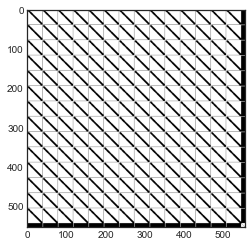

In [787]:
plt.imshow(sigma_w_inv != 0)

In [788]:
_model =  A.dot(np.linalg.solve(sigma_w_inv, B)).reshape(e.bf.shape)

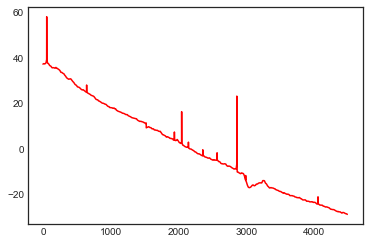

In [789]:
#plt.plot(e.bf[100], lw=0.3, c='k')
plt.plot(_model[103], c='r')

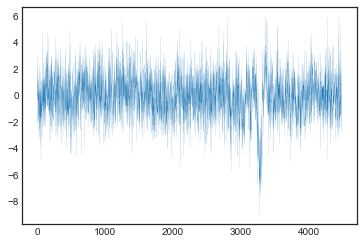

In [799]:
pdx = 10
plt.plot(e.bf[pdx] - _model[pdx], lw=0.1)

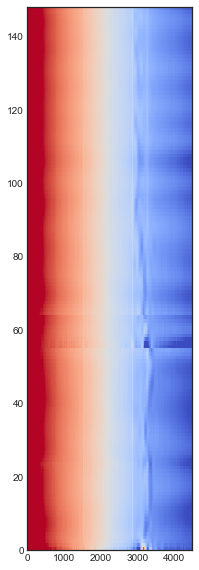

In [807]:
plt.figure(figsize=(4, 10))
plt.pcolormesh(_model, vmin=-30, vmax=30, cmap='coolwarm')
plt.gca().set_aspect(100)

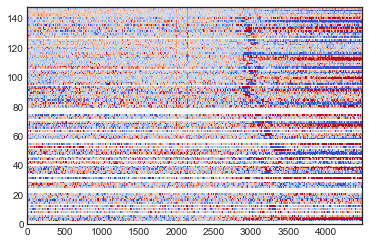

In [779]:
plt.pcolormesh(e.bf - e._model, vmin=-3, vmax=3, cmap='coolwarm')

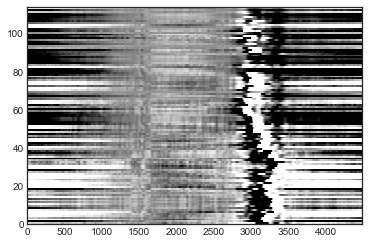

In [548]:
idx, jdx = 1, 12
plt.pcolormesh(U[:, idx:jdx].dot(np.diag(s[idx:jdx])).dot(V[idx:jdx]).T, vmin=-1, vmax=1)

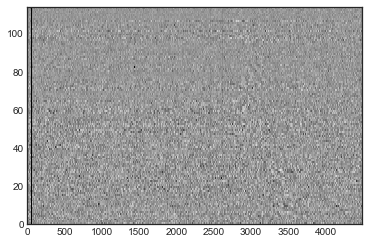

In [549]:
plt.pcolormesh(e.bf[np.isfinite(e.bf.mean(axis=1)), :] - U.dot(np.diag(s)).dot(V).T, vmin=-10, vmax=10)

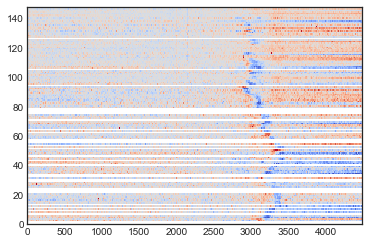

In [198]:
plt.pcolormesh(e.bf - e._model.mean(axis=0), vmin=-10, vmax=10, cmap='coolwarm')